# **Projeto de Disciplina** - BigData e Processamento Distribuído
**Alunos:**
* Eduardo Junior Pereira
* Gabriel Ramalho Grotto
___
# 1. Visão geral e objetivos
**Objetivo geral:** 
> O objetivo desse projeto é realizar um ciclo completo de ciência de dados utilizando PySpark.

**Objetivos específicos:**
> *Parte I: Exploração de Dados:* 
* realizar no mínimo **2 análises** (estatística, análise 
com gráficos, ...);
* realizar no mínimo **3 transformações** (filtragem, remoção de características, remoção/troca de calores nulos, normalizações, ...).

> *Parte II: Criação de um Modelo e Análise de Resultados:* 
* rodar um algoritmo da biblioteca MLlib do Spark; 
* motivar a escolha do algoritmo; 
* dividir os dados utilizando alguma metodologia de validação (*cross-validation*, 60-40, 80-20, ...); 
* validar a performance do modelo e analisar os resultados.
___

# 2. Dataset
 
Para a realização dos objetivos propostos, foi escolhido o seguinte conjunto de dados:

>**Título do Dataset:** Credit Approval 
* *Disponível em:* [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/credit+approval "UCI Machine Learning Repository - Fonte do Dataset") 
* *Número total de registros:* 690 
* *Número total de features:* 15 + variável alvo 
* [Descrição das features](http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.names "Clique para fazer o download do .txt com a descrição das features")  
___

>**Informações relevantes**
* Os valores no conjunto de dados foram convertidos em símbolos para proteger a confidencialidade dos dados.
* O conjunto de dados refere-se a pedidos de crédito e, nesse sentido, ao longo desse trabalho procurou-se contribuir para a discussão acerca das decisões de uma empresa em aprovar ou negar esses pedidos.
* A análise consiste em uma tarefa de `classificação binária` e, em suma, procurou-se avaliar a performance do algoritmo de classificação `Logistic Regression`.
* O algoritmo está localizados no módulo `pyspark.ml.classification` e para maiores informações acessar a [documentação.](https://spark.apache.org/docs/latest/ml-classification-regression.html#classification "Clique para acessar a documentação.")

___
# 3. Configuração do projeto
> 3.1. Instalar PySpark no Google Colab
>
> 3.2. Importar bibliotecas e inicializar uma  sessão local - *SparkSession*
>
> 3.3. Carregar os dados
___

## 3.1. Instalar PySpark no Google Colab
> **Fonte:** [Google Colab](https://colab.research.google.com/github/carlosfab/sigmoidal_ai/blob/master/Big_Data_Como_instalar_o_PySpark_no_Google_Colab.ipynb "Como instalar o PySpark no Google Colab ")

In [1]:
# Atualizacao necessária para a execucao no Google Colab
!apt-get update
# Instalar as dependências necessárias para a execução no Google Colab
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark
print('-'*52+'\nAtualização e instalação de dependências concluídas!\n'+'-'*52)

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [867 kB]
Hit:13 http://ppa.laun

## 3.2. Importar bibliotecas 

In [26]:
# Tornar o pyspark "importável"
import findspark
findspark.init('spark-3.2.0-bin-hadoop3.2')

# Importar pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
from pyspark.sql.functions import col, sum, count, when, isnan
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, RobustScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Bibliotecas necessárias para a manipulação dos dados
import os
import urllib
import pandas as pd
import numpy as np

# Bibliotecas necessárias para a visualização dos dados
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import seaborn as sns

# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

## 3.3. Inicializar uma sessão local (*SparkSession*) e carregar os dados

In [3]:
# Iniciar uma sessão local
spark = SparkSession.builder.appName('crx-data-pyspark').getOrCreate()

# Download do http para arquivo local
!wget --quiet 'http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data'

# Carregar os dados
df_spark = spark.read.csv('/content/crx.data', header=False)

# Visualizar algumas informações sobre os tipos de dados de cada coluna
print("-"*50+"\nInformações sobre os tipos de dados de cada coluna\n"+"-"*50+
      f'\nTotal de linhas: {df_spark.count()}\n'+
      f'Total de colunas: {len(df_spark.columns)}\n'+'-'*50)
df_spark.printSchema()

# Visualizar as cinco primeiras linhas do dataframe
df_spark.show(5)

--------------------------------------------------
Informações sobre os tipos de dados de cada coluna
--------------------------------------------------
Total de linhas: 690
Total de colunas: 16
--------------------------------------------------
root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)

+---+-----+-----+---+---+---+---+----+---+---+----+----+----+-----+----+----+
|_c0|  _c1|  _c2|_c3|_c4|_c5|_c6| _c7|_c8|_c9|_c10|_c11|_c12| _c13|_c14|_c15|
+---+-----+-----+---+---+-

___
# 4. Parte I - Exploração dos dados
> 4.1. Renomear as colunas do dataframe
>
> 4.2. Verificar a existência registros nulos e ausentes
>
> 4.3. Análise e tratamento das variáveis categóricas
>
> 4.4. Distribuição dos dados
>
> 4.5. Verificar a correlação entre as variáveis
>
> 4.6. Extração de variáveis
>
> 4.7. Particionamento do conjunto de dados
>
> 4.8. Escalonamento dos dados - `RobustScaler`
>
> 4.9. `VectorAssembler`
___

## 4.1. Renomear as colunas do dataframe



In [4]:
def rename_columns(df, columns):
    """
    Função para renomear as colunas do dataframe
    ====Parâmetros====
    df -- dataframe no qual as colunas serão renomeadas
    columns -- dicionário com os nomes das colunas, onde:
        * As CHAVES do dicionário correspondem aos NOMES ANTIGOS das colunas; 
        * Os VALORES de cada chave correspondem aos NOVOS NOMES que serão 
        atribuídos às colunas.
    """
    if isinstance(columns, dict):
        for old_name, new_name in columns.items():
            df = df.withColumnRenamed(old_name, new_name)
        return df
    else:
        raise ValueError("'columns' deve ser um dicionário do tipo\n {'old_name_1':'new_name_1', 'old_name_2':'new_name_2'}")

new_columns = {'_c0':'Gender','_c1':'Age','_c2':'Debt','_c3':'Married',
               '_c4':'BankCustomer','_c5':'EducationLevel','_c6':'Ethnicity',
               '_c7':'YearsEmployed','_c8':'PriorDefault','_c9':'Employed',
               '_c10':'CreditScore','_c11':'DriversLicense','_c12':'Citizen',
               '_c13':'ZipCode','_c14':'Income','_c15':'ApprovalStatus'}

df_spark = rename_columns(df_spark, new_columns)
df_spark.show(5)

+------+-----+-----+-------+------------+--------------+---------+-------------+------------+--------+-----------+--------------+-------+-------+------+--------------+
|Gender|  Age| Debt|Married|BankCustomer|EducationLevel|Ethnicity|YearsEmployed|PriorDefault|Employed|CreditScore|DriversLicense|Citizen|ZipCode|Income|ApprovalStatus|
+------+-----+-----+-------+------------+--------------+---------+-------------+------------+--------+-----------+--------------+-------+-------+------+--------------+
|     b|30.83|    0|      u|           g|             w|        v|         1.25|           t|       t|         01|             f|      g|  00202|     0|             +|
|     a|58.67| 4.46|      u|           g|             q|        h|         3.04|           t|       t|         06|             f|      g|  00043|   560|             +|
|     a|24.50|  0.5|      u|           g|             q|        h|          1.5|           t|       f|          0|             f|      g|  00280|   824|        

## 4.2. Verificar a existência registros nulos e ausentes

In [5]:
# Verificar a existência de valores nulos 
print('-'*35+'\nTotal de valores nulos por coluna:\n'+'-'*35)
df_spark.select([count(when(col(c).isNull(), c)).alias(c) for c in df_spark.columns]).show(1, vertical=True)

-----------------------------------
Total de valores nulos por coluna:
-----------------------------------
-RECORD 0-------------
 Gender         | 0   
 Age            | 0   
 Debt           | 0   
 Married        | 0   
 BankCustomer   | 0   
 EducationLevel | 0   
 Ethnicity      | 0   
 YearsEmployed  | 0   
 PriorDefault   | 0   
 Employed       | 0   
 CreditScore    | 0   
 DriversLicense | 0   
 Citizen        | 0   
 ZipCode        | 0   
 Income         | 0   
 ApprovalStatus | 0   



In [6]:
# Verificar a existência de valores ausentes 
print('-'*37+'\nTotal de valores ausentes por coluna:\n'+'-'*37)
df_spark.select([count(when(isnan(c), c)).alias(c) for c in df_spark.columns]).show(1, vertical=True)

-------------------------------------
Total de valores ausentes por coluna:
-------------------------------------
-RECORD 0-------------
 Gender         | 0   
 Age            | 0   
 Debt           | 0   
 Married        | 0   
 BankCustomer   | 0   
 EducationLevel | 0   
 Ethnicity      | 0   
 YearsEmployed  | 0   
 PriorDefault   | 0   
 Employed       | 0   
 CreditScore    | 0   
 DriversLicense | 0   
 Citizen        | 0   
 ZipCode        | 0   
 Income         | 0   
 ApprovalStatus | 0   



## 4.3. Análise e tratamento das variáveis categóricas

In [7]:
# Verificar variáveis categóricas
for cols in new_columns.values():
    print('-'*(len(cols)+44)+f'\nVerificando se "{cols}" é uma variável categórica:\n'+'-'*(len(cols)+44))
    df_spark.groupBy(cols).count().show()

--------------------------------------------------
Verificando se "Gender" é uma variável categórica:
--------------------------------------------------
+------+-----+
|Gender|count|
+------+-----+
|     b|  468|
|     a|  210|
|     ?|   12|
+------+-----+

-----------------------------------------------
Verificando se "Age" é uma variável categórica:
-----------------------------------------------
+-----+-----+
|  Age|count|
+-----+-----+
|24.50|    6|
|17.42|    1|
|23.92|    3|
|26.25|    1|
|36.33|    2|
|57.58|    1|
|32.17|    1|
|31.58|    1|
|29.58|    3|
|17.67|    2|
|16.33|    3|
|57.42|    1|
|41.50|    1|
|62.75|    1|
|30.17|    3|
|29.42|    2|
|30.42|    1|
|25.50|    1|
|44.25|    2|
|45.33|    1|
+-----+-----+
only showing top 20 rows

------------------------------------------------
Verificando se "Debt" é uma variável categórica:
------------------------------------------------
+------+-----+
|  Debt|count|
+------+-----+
|   8.5|    5|
| 6.665|    1|
|     7|    8

___
___
**Notas:**
> Durante a checagem das variáveis categóricas, observou-se a existência de registros iguais a **"?"**
para algumas dessas variáveis. São elas:
* Gender
* Married
* BankCustomer
* EducationLevel
* Ethinicity
>
> Uma vez que os registros iguais a **"?"** representam uma pequena fração do total do conjunto de dados, optou-se por excluir as linhas nas quais esses valores aparecem.
___
___

In [8]:
# Excluir linhas com os registros iguais a "?" 
df_spark = df_spark.where("Gender!='?'")
df_spark = df_spark.where("Married!='?'")
df_spark = df_spark.where("BankCustomer!='?'")
df_spark = df_spark.where("EducationLevel!='?'")
df_spark = df_spark.where("Ethnicity!='?'")

# Verificar novamente a existência de registros iguais a ?
for cols in ['Gender','Married','BankCustomer','EducationLevel','Ethnicity']:
    print('-'*(len(cols)+64)+f'\nVerificando a existência de registros iguais a "?" na coluna "{cols}":\n'+'-'*(len(cols)+64))
    df_spark.select(cols).distinct().show()

----------------------------------------------------------------------
Verificando a existência de registros iguais a "?" na coluna "Gender":
----------------------------------------------------------------------
+------+
|Gender|
+------+
|     b|
|     a|
+------+

-----------------------------------------------------------------------
Verificando a existência de registros iguais a "?" na coluna "Married":
-----------------------------------------------------------------------
+-------+
|Married|
+-------+
|      l|
|      y|
|      u|
+-------+

----------------------------------------------------------------------------
Verificando a existência de registros iguais a "?" na coluna "BankCustomer":
----------------------------------------------------------------------------
+------------+
|BankCustomer|
+------------+
|           g|
|           p|
|          gg|
+------------+

------------------------------------------------------------------------------
Verificando a existência de r

In [9]:
# Indexação das variáveis categóricas

# Criar dicionário do tipo {'input_cols':'output_cols'}
dict_cols = {'Gender':'Gender_idx','Married':'Married_idx',
             'BankCustomer':'BankCustomer_idx',
             'EducationLevel':'EducationLevel_idx',
             'Ethnicity':'Ethnicity_idx','PriorDefault':'PriorDefault_idx',
             'Employed':'Employed_idx', 'CreditScore':'CreditScore_idx',
             'DriversLicense':'DriversLicense_idx','Citizen':'Citizen_idx',
             'ApprovalStatus':'Y_bin'}

indexer = StringIndexer(inputCols=list(dict_cols.keys()), 
                        outputCols=list(dict_cols.values()))

df_spark_idx = indexer.fit(df_spark).transform(df_spark)

# Verificar indexação das variáveis categóricas
for keys, values  in dict_cols.items():
    print('-'*(len(keys)+40)+f'\nVerificando a indexação da varriável "{keys}":\n'+'-'*(len(keys)+40))
    df_spark_idx.select(keys, values).distinct().orderBy(values, ascending=True).show()

----------------------------------------------
Verificando a indexação da varriável "Gender":
----------------------------------------------
+------+----------+
|Gender|Gender_idx|
+------+----------+
|     b|       0.0|
|     a|       1.0|
+------+----------+

-----------------------------------------------
Verificando a indexação da varriável "Married":
-----------------------------------------------
+-------+-----------+
|Married|Married_idx|
+-------+-----------+
|      u|        0.0|
|      y|        1.0|
|      l|        2.0|
+-------+-----------+

----------------------------------------------------
Verificando a indexação da varriável "BankCustomer":
----------------------------------------------------
+------------+----------------+
|BankCustomer|BankCustomer_idx|
+------------+----------------+
|           g|             0.0|
|           p|             1.0|
|          gg|             2.0|
+------------+----------------+

------------------------------------------------------


___
___
**Notas:**
> Algumas features possuem mais de dois valores e para evitar que o algoritmo atribua importância maior aos pesos maiores, decidiu-se utilizar o `OneHotEncoder`:
>
> Features categóricas que serão codificadas utilizando o OneHotEncoder:
* Married
* BankCustomer
* EducationLevel
* Ethinicity
* CreditScore
* Citizen
___
___

In [10]:
# Codificação dummy das variáveis categóricas utilizando OneHotEncoder
# Criar dicionário do tipo {'input_cols':'output_cols'}
dict_cols_oh = {'Married_idx':'Married_oh','BankCustomer_idx':'BankCustomer_oh',
                'EducationLevel_idx':'EducationLevel_oh','Ethnicity_idx':'Ethnicity_oh',
                'CreditScore_idx':'CreditScore_oh','Citizen_idx':'Citizen_oh'}

onehot = OneHotEncoder(inputCols=list(dict_cols_oh.keys()),
                       outputCols=list(dict_cols_oh.values()))

df_spark_oh = onehot.fit(df_spark_idx).transform(df_spark_idx)

# Verificar representação dummy das variáveis categóricas
for keys, values  in dict_cols_oh.items():
    print('-'*(len(keys)+50)+f'\nVerificando a representação dummy da varriável "{keys}":\n'+'-'*(len(keys)+50))
    df_spark_oh.select(keys, values).distinct().orderBy(keys, ascending=True).show()

-------------------------------------------------------------
Verificando a representação dummy da varriável "Married_idx":
-------------------------------------------------------------
+-----------+-------------+
|Married_idx|   Married_oh|
+-----------+-------------+
|        0.0|(2,[0],[1.0])|
|        1.0|(2,[1],[1.0])|
|        2.0|    (2,[],[])|
+-----------+-------------+

------------------------------------------------------------------
Verificando a representação dummy da varriável "BankCustomer_idx":
------------------------------------------------------------------
+----------------+---------------+
|BankCustomer_idx|BankCustomer_oh|
+----------------+---------------+
|             0.0|  (2,[0],[1.0])|
|             1.0|  (2,[1],[1.0])|
|             2.0|      (2,[],[])|
+----------------+---------------+

--------------------------------------------------------------------
Verificando a representação dummy da varriável "EducationLevel_idx":
--------------------------------

In [11]:
# Pré-seleção de features - excluir apenas variáveis sem a representação dummy
cols_to_drop_oh = ['Gender','Married','BankCustomer','EducationLevel','Ethnicity',
                   'PriorDefault','Employed','CreditScore','DriversLicense','Citizen',
                   'ApprovalStatus','Married_idx','BankCustomer_idx','EducationLevel_idx',
                   'Ethnicity_idx','CreditScore_idx','Citizen_idx']
df_spark_oh = df_spark_oh.drop(*cols_to_drop_oh)

# Modificar o Dtype das features
# Criar dicionário do tipo {'feature':'dtype'}
dict_dtypes = {'Age':'float', 'Debt':'float','YearsEmployed':'float',
               'ZipCode':'integer','Income':'float'}
for keys, values in dict_dtypes.items():
    df_spark_oh = df_spark_oh.withColumn(keys, col(keys).cast(values))

df_spark_oh.printSchema()

root
 |-- Age: float (nullable = true)
 |-- Debt: float (nullable = true)
 |-- YearsEmployed: float (nullable = true)
 |-- ZipCode: integer (nullable = true)
 |-- Income: float (nullable = true)
 |-- Gender_idx: double (nullable = false)
 |-- PriorDefault_idx: double (nullable = false)
 |-- Employed_idx: double (nullable = false)
 |-- DriversLicense_idx: double (nullable = false)
 |-- Y_bin: double (nullable = false)
 |-- Married_oh: vector (nullable = true)
 |-- BankCustomer_oh: vector (nullable = true)
 |-- EducationLevel_oh: vector (nullable = true)
 |-- Ethnicity_oh: vector (nullable = true)
 |-- CreditScore_oh: vector (nullable = true)
 |-- Citizen_oh: vector (nullable = true)



## 4.4. Distribuição dos dados

In [12]:
# Visualizar estatísticas descritivas das features do dataframe
print('-'*42+'\nEstatísticas descritivas da variável alvo:\n'+'-'*42)
df_spark_oh.select('Y_bin').describe().show()

print('-'*50+'\nEstatísticas descritivas das variáveis preditoras:\n'+'-'*50)
df_spark_oh.drop('Y_bin').describe().show()

------------------------------------------
Estatísticas descritivas da variável alvo:
------------------------------------------
+-------+-------------------+
|summary|              Y_bin|
+-------+-------------------+
|  count|                671|
|   mean|0.44709388971684055|
| stddev|0.49756396586447815|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+

--------------------------------------------------
Estatísticas descritivas das variáveis preditoras:
--------------------------------------------------
+-------+------------------+-----------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+
|summary|               Age|             Debt|     YearsEmployed|           ZipCode|            Income|         Gender_idx|   PriorDefault_idx|       Employed_idx| DriversLicense_idx|
+-------+------------------+-----------------+------------------+--------------

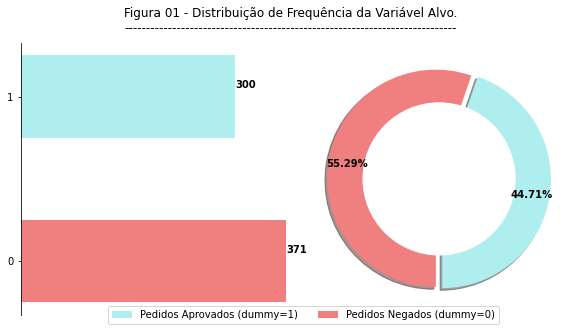

In [13]:
# Frequência de ocorrência da variável alvo
aproved = df_spark_oh.where('Y_bin == 1').count()
not_aproved = df_spark_oh.where('Y_bin == 0').count()

# Criar canvas para plotar os gráficos
fig1 = plt.figure(constrained_layout=False, figsize=(10,5))
fig1.suptitle('Figura 01 - Distribuição de Frequência da Variável Alvo.\n'+'-'*76)
# Criar gridspec
gs = gridspec.GridSpec(nrows=1, ncols=2, hspace=0.2, wspace=0)
# Parâmetros gerais para plotar os gráficos
sizes = [aproved,not_aproved] 
labels=['Pedidos Aprovados (dummy=1)','Pedidos Negados (dummy=0)']
colors=['paleturquoise','lightcoral']

# Plotar barras com o total de cada ocorrência da variável alvo - ax1[0,0]
ax1 = fig1.add_subplot(gs[0,0])
ax1.get_xaxis().set_visible(False)
ax1.set_xlabel(f'Total de ocorrências', fontsize=10)
ax1.set_yticklabels([1,0])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.invert_yaxis()
plt.barh(labels, sizes, color=colors, height=0.5)
for idx in ax1.patches:
    plt.text(idx.get_width(), idx.get_y() + 0.2,
             str(int(idx.get_width())),
             fontweight='bold')

# Plotar gráfico donut com % de ocorrência da variável alvo - ax2[0,1]
ax2 = fig1.add_subplot(gs[0,1])
ax2.pie(x=sizes, colors=colors,autopct='%.2f%%', pctdistance=0.83,shadow=True, 
        startangle=270, explode=(0.03,0.03), textprops={'fontweight':'bold'})
ax2.legend(labels=labels, loc='center', bbox_to_anchor=(0,0),ncol=2)
# Criar círculo branco para plotar o donut
white_circle = plt.Circle((0,0),0.7,color='white')
p = plt.gcf()
_=p.gca().add_artist(white_circle)

plt.savefig("Figura01_DistFrequenciaVariavelAlvo.png", transparent=True)

___
___
**Notas:**
> De acordo com o gráfico acima, podemos observar que houve um total de **671** registros, dos quais **300** *foram aprovados* e **371** *negados*, o que por sua vez correspondem respectivamente aos percentuais de 55,29% e 44,71% do total de pedidos registrados.
>
> O próximo passo consiste em verificar a distribuição de frequência das variáveis: **Age, Debt, YearsEmployed, ZipCode, Income.**
___
___

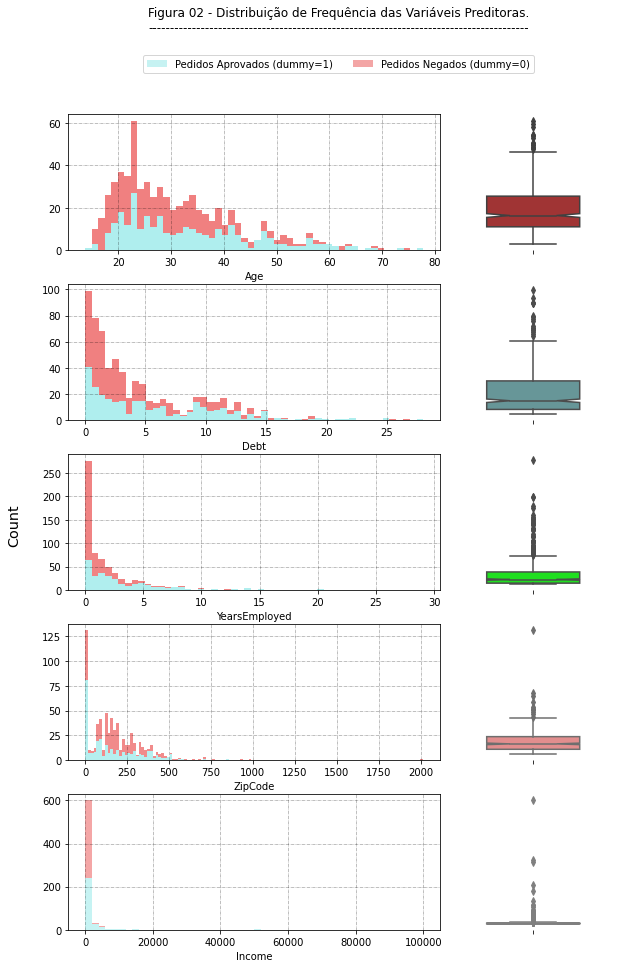

In [14]:
# Criar objeto pandasDataFrame 
df_pd = df_spark_oh.toPandas()

# Extrair nome das features
cols_names = list(df_pd.columns[0:5])

# Extrair df para pedidos_aprovados e pedidos_negados
df_aprovados = df_pd[df_pd['Y_bin'] == 1]
df_negados = df_pd[df_pd['Y_bin'] == 0]

# Criar canvas para plotar os gráficos
fig2 = plt.figure(constrained_layout=False, figsize=(10,15))
fig2.suptitle('Figura 02 - Distribuição de Frequência das Variáveis Preditoras.\n'+'-'*87)
fig2.text(0.05,0.5, "Count", ha="center", va="center", rotation=90, size='x-large')
# Criar gridspec
gs = gridspec.GridSpec(nrows=5, ncols=3, hspace=0.25, wspace=0)

# Plotar gráficos
for a in range(5):
    ax = fig2.add_subplot(gs[a,:2])
    # Plotar histogramas
    for idx, ax in enumerate(fig2.axes):
        ax.figure
        binwidth = (max(df_aprovados[cols_names[idx]])-min(df_negados[cols_names[idx]]))/50
        ax.hist([df_aprovados[cols_names[idx]], df_negados[cols_names[idx]]],
                bins = np.arange(min(df_pd[cols_names[idx]]),
                                 max(df_pd[cols_names[idx]])+binwidth, binwidth),
                alpha=0.7, stacked=True, label=labels, color=colors)
        ax.set_xlabel(cols_names[idx])
        ax.grid(axis='both',color='black',alpha=0.5,linestyle='-.',linewidth=0.5)

# Plotar BoxPlot para variável 'Age'
ax6 = fig2.add_subplot(gs[0,-1])
ax6 = sns.boxplot(y=df_pd['Age'],notch=True, width=0.5, color='firebrick')
ax6.set_ylabel('')
ax6.get_yaxis().set_visible(False)
ax6.set_frame_on(False)

# Plotar BoxPlot para variável 'Debt'
ax7 = fig2.add_subplot(gs[1,-1])
ax7 = sns.boxplot(y=df_pd['Debt'],notch=True, width=0.5, color='cadetblue')
ax7.set_ylabel('')
ax7.get_yaxis().set_visible(False)
ax7.set_frame_on(False)

# Plotar BoxPlot para variável 'YearsEmployed'
ax8 = fig2.add_subplot(gs[2,-1])
ax8 = sns.boxplot(y=df_pd['YearsEmployed'],notch=True, width=0.5, color='lime')
ax8.set_ylabel('')
ax8.get_yaxis().set_visible(False)
ax8.set_frame_on(False)

# Plotar BoxPlot para variável 'ZipCode'
ax9 = fig2.add_subplot(gs[3,-1])
ax9 = sns.boxplot(y=df_pd['ZipCode'],notch=True, width=0.5, color='lightcoral')
ax9.set_ylabel('')
ax9.get_yaxis().set_visible(False)
ax9.set_frame_on(False)

# Plotar BoxPlot para variável 'Income'
ax10 = fig2.add_subplot(gs[4,-1])
ax10 = sns.boxplot(y=df_pd['Income'],notch=True, width=0.5, color='wheat')
ax10.set_ylabel('')
ax10.get_yaxis().set_visible(False)
ax10.set_frame_on(False)

fig2.legend(labels=['Pedidos Aprovados (dummy=1)','Pedidos Negados (dummy=0)'], 
            ncol=2, loc='upper center', bbox_to_anchor=(0.47,0.85))
plt.savefig("Figura02_DistFrequenciaVariaveisPreditoras.png", transparent=True)

___
___
**Notas:**
> De acordo com a Figura 02 é possível observar uma grande quantidade de *Outliers* para as variáveis analisadas.
___
___

## 4.5. Verificar a correlação entre as variáveis

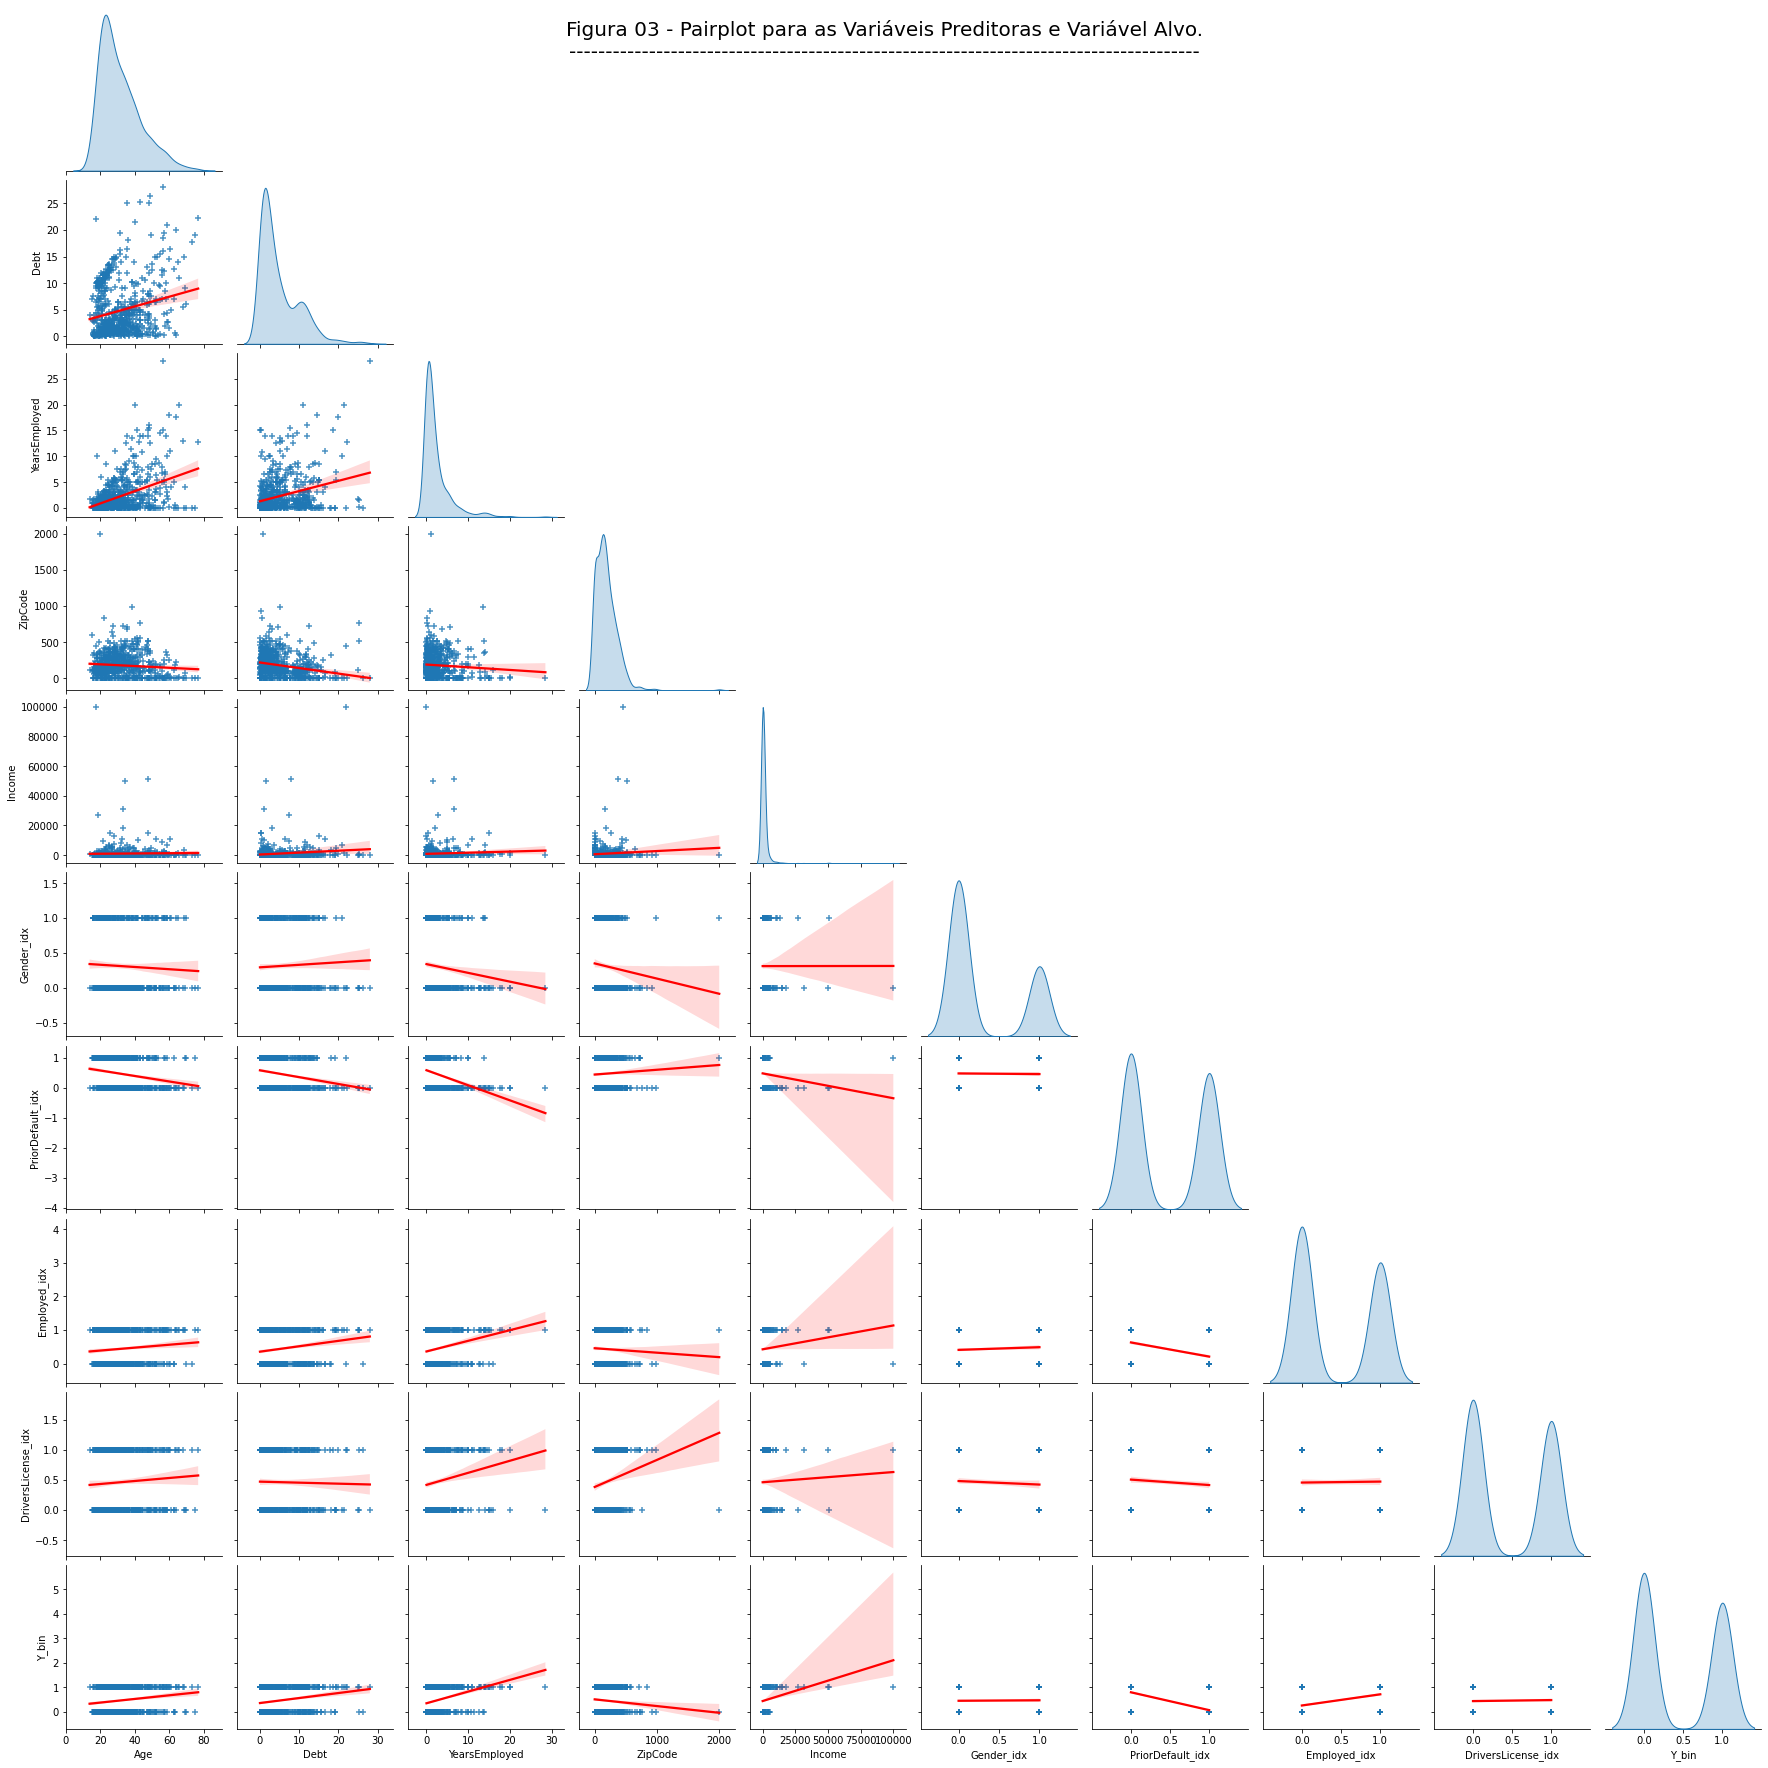

In [15]:
# Verificar multicolinearidade entre as variáveis
# Plotar PairPlot para as variáveis preditoras e variável alvo
pairplot = sns.pairplot(df_pd,corner=True, diag_kind='kde',kind='reg',
                        plot_kws={'line_kws':{'color':'red'},'marker':'+'})
pairplot.fig.suptitle('Figura 03 - Pairplot para as Variáveis Preditoras e Variável Alvo.\n'+'-'*87, fontsize=20)

plt.show()
pairplot.figure.savefig("Figura03_Multicolinearidade-PairPlot.png", transparent=True)

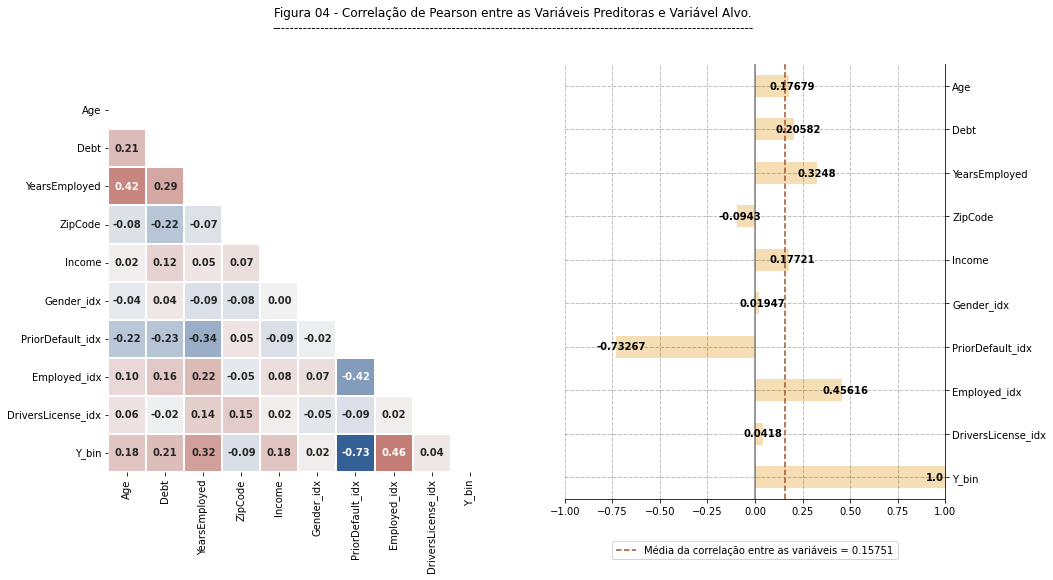

In [16]:
# Criar canvas para plotar os gráficos
fig4 = plt.figure(constrained_layout=False, figsize=(15,8))
fig4.suptitle('Figura 04 - Correlação de Pearson entre as Variáveis Preditoras e Variável Alvo.\n'+'-'*110)

# Criar gridspec
gs = gridspec.GridSpec(nrows=1, ncols=2, hspace=0.5)

# Plotar heatmap - Criar matriz de correlação de Pearson
matriz = df_pd.drop('Y_bin', axis=1)
matriz = df_pd.corr()
# Criar uma paleta de divergência (s=saturação, l=luminosidade, n=numero cores)
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9,center="light", as_cmap=True)
# Criar uma máscara
mascara = np.triu(np.ones_like(matriz, dtype=bool))
ax1 = fig4.add_subplot(gs[0,0])
ax1 = sns.heatmap(matriz, mask=mascara, center=0, fmt='.2f', square=True, 
                  cmap=cmap,cbar=False, linewidths=1, annot=True, 
                  annot_kws={'fontsize':10,'fontweight':'bold'})

# Plotar gráfico de barras com as correlações
ax2 = fig4.add_subplot(gs[0,1])
ax2 = df_pd.corrwith(df_pd['Y_bin']).plot(kind='barh', color='wheat')
ax2.invert_yaxis()
ax2.yaxis.tick_right()
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.grid(axis='both',color='black',alpha=0.5,linestyle='-.',linewidth=0.5)
plt.xlim([-1,1])
# Acrescentar reta com "correlação média"
mean = np.mean(matriz['Y_bin'])
ax2.axvline(mean, ls='--', color='sienna')
ax2.axvline(x=0, color="grey")

red_line = mlines.Line2D([],[],color='sienna',linestyle='--', 
                         label='Média da correlação entre as variáveis = %.5f' %mean,)
ax2.legend(handles=[red_line], loc='lower center', bbox_to_anchor=(0.5,-0.15))

# Criar anotações nas barras
for i in ax2.patches:
    plt.text(i.get_width() - 0.1,
             i.get_y() + 0.25,
             str(round((i.get_width()), 5)),
             fontsize=10,
             fontweight='bold',
             color='black',
             va='center')
# Determinar tamanho da fonte no eixo y
for tick in ax2.yaxis.get_ticklabels():
    tick.set_fontsize('10')
    
plt.savefig("Figura04_CorrelacaoPearson.png", transparent=True)

___
___
**Notas:**
>* De acordo com as Figuras 03 e 04, podemos sugerir a presença de alta correlação entre as variáveis `Age` e `YearsEmployed`, podendo indicar padrões de multicolinearidade. 
>* A variável `YearsEmployed` também apresentou significativa correlação com a variável alvo `Y_bin` e com a variável `Debt`.
>* As variáveis `Income` e `Employed_idx` também apresentaram correlação significativa entre elas e com a variável alvo `Y_bin`.
___
___


## 4.6. Extração de variáveis

___
___
**Notas:**
>* Com a intenção de evitar erros no processo de classificação, decidiu-se por excluir as variáveis:
    * `Age` 
    * `ZipCode`  
    * `Gender_idx` 
    * `DriversLicense_idx`
    * `Married_oh`,
    * `BankCustomer_oh`
    * `Ethnicity_oh`
    * `Citizen_oh`. 
>* Dentre as motivações para excluí-las podemos citar:
    1. Existência de correlação significativa com outra variável preditora ou com a variável alvo;
    2. Evidência de um grande número de *outliers*;
    3. Evitar vieses de classifação por gênero, etnia ou similares.
___
___


In [17]:
# Seleção de features
cols_to_drop = ['Age','ZipCode','Gender_idx','DriversLicense_idx','Married_oh',
                'BankCustomer_oh','Ethnicity_oh','Citizen_oh']

df_ready_spark = df_spark_oh.drop(*cols_to_drop)
df_ready_spark.show(5)

+-----+-------------+------+----------------+------------+-----+-----------------+--------------+
| Debt|YearsEmployed|Income|PriorDefault_idx|Employed_idx|Y_bin|EducationLevel_oh|CreditScore_oh|
+-----+-------------+------+----------------+------------+-----+-----------------+--------------+
|  0.0|         1.25|   0.0|             0.0|         1.0|  1.0|   (13,[2],[1.0])|(22,[1],[1.0])|
| 4.46|         3.04| 560.0|             0.0|         1.0|  1.0|   (13,[1],[1.0])|(22,[4],[1.0])|
|  0.5|          1.5| 824.0|             0.0|         0.0|  1.0|   (13,[1],[1.0])|(22,[0],[1.0])|
| 1.54|         3.75|   3.0|             0.0|         1.0|  1.0|   (13,[2],[1.0])|(22,[6],[1.0])|
|5.625|         1.71|   0.0|             0.0|         0.0|  1.0|   (13,[2],[1.0])|(22,[0],[1.0])|
+-----+-------------+------+----------------+------------+-----+-----------------+--------------+
only showing top 5 rows



## 4.7. Particionamento do conjunto de dados

In [18]:
# Particionar os dados
df_train, df_test = df_ready_spark.randomSplit([0.8, 0.2], seed=123)

print('-'*32+'\nConjunto de dados de TREINAMENTO\n'+'-'*32+
      f'\nTotal de linhas: {df_train.count()}\n'+
      f'Total de colunas: {len(df_train.columns)}\n'+'-'*32+
      '\n\n'+'-'*26+'\nConjunto de dados de TESTE\n'+'-'*26+
      f'\nTotal de linhas: {df_test.count()}\n'+
      f'Total de colunas: {len(df_test.columns)}\n'+'-'*26)

--------------------------------
Conjunto de dados de TREINAMENTO
--------------------------------
Total de linhas: 535
Total de colunas: 8
--------------------------------

--------------------------
Conjunto de dados de TESTE
--------------------------
Total de linhas: 136
Total de colunas: 8
--------------------------


## 4.8. Escalonamento dos dados

___
___
**Notas**
>* Devido a presença de *outliers* no conjunto de dados decidiu-se por usar o `RobustScaler`. 
>* O RobustScaler remove a mediana e dimensiona os dados de acordo com o **intervalo de quantil**. 
>* O intervalo de quantil é, por padrão, um intervalo de quantil entre:
>  * **1º quartil** = 25º quantil;  
>  * e o **3º quartil** = 75º quantil  

___
___

In [19]:
# Contruir o pipeline para o RobustScaler
cols_to_scale = ['Debt','YearsEmployed','Income']
assemblers = [VectorAssembler(inputCols=[col],outputCol=col+'_vec') for col in cols_to_scale]
scalers = [RobustScaler(inputCol=col+'_vec',outputCol=col+'_scaled') for col in cols_to_scale] 
pipeline = Pipeline(stages = assemblers + scalers)

# Rodando o pipeline 
scalerModel = pipeline.fit(df_train)
df_train_scaled = scalerModel.transform(df_train)
df_test_scaled = scalerModel.transform(df_test)

# Verificar df_train_scaled
print('-'*30+'\nConjunto de dados de ORIGINAIS\n'+'-'*30)
df_train.show(5)
# Verificar df_train
print('-'*32+'\nConjunto de dados de ESCALONADOS\n'+'-'*32)
df_train_scaled.show(5)

------------------------------
Conjunto de dados de ORIGINAIS
------------------------------
+----+-------------+------+----------------+------------+-----+-----------------+--------------+
|Debt|YearsEmployed|Income|PriorDefault_idx|Employed_idx|Y_bin|EducationLevel_oh|CreditScore_oh|
+----+-------------+------+----------------+------------+-----+-----------------+--------------+
| 0.0|          0.0|   0.0|             1.0|         0.0|  0.0|   (13,[5],[1.0])|(22,[0],[1.0])|
| 0.0|          0.0|   0.0|             1.0|         0.0|  0.0|  (13,[12],[1.0])|(22,[0],[1.0])|
| 0.0|          0.0|   1.0|             1.0|         1.0|  0.0|   (13,[5],[1.0])|(22,[8],[1.0])|
| 0.0|        0.085|   0.0|             0.0|         0.0|  1.0|   (13,[7],[1.0])|(22,[0],[1.0])|
| 0.0|         0.25|   0.0|             1.0|         0.0|  0.0|   (13,[4],[1.0])|(22,[0],[1.0])|
+----+-------------+------+----------------+------------+-----+-----------------+--------------+
only showing top 5 rows

---------

## 4.9. VectorAssembler

___
___
**Notas:**
>* Spark requer que toda a informação que será passada para um algoritmo de ML seja convertida em um único vetor.
>* Para fazer isso, usaremos `VectorAssembler`.
___
___

In [20]:
cols_to_use = ['PriorDefault_idx','Employed_idx','EducationLevel_oh',
               'CreditScore_oh','Debt_scaled','YearsEmployed_scaled','Income_scaled']

vec = VectorAssembler(inputCols=cols_to_use, outputCol='features')

df_train_vec = vec.transform(df_train_scaled).select('features','Y_bin')
df_test_vec = vec.transform(df_test_scaled).select('features','Y_bin')

# Verificar schema() do df_train_vec
print('-'*32+'\nConjunto de dados de TREINAMENTO\n'+
      f'Total de registros: {df_train_vec.count()}\n'+'-'*32)
df_train_vec.printSchema()

# Verificar schema() do df_test_vec
print('-'*26+'\nConjunto de dados de TESTE\n'+
      f'Total de registros: {df_test_vec.count()}\n'+'-'*26)
df_test_vec.printSchema()

--------------------------------
Conjunto de dados de TREINAMENTO
Total de registros: 535
--------------------------------
root
 |-- features: vector (nullable = true)
 |-- Y_bin: double (nullable = false)

--------------------------
Conjunto de dados de TESTE
Total de registros: 136
--------------------------
root
 |-- features: vector (nullable = true)
 |-- Y_bin: double (nullable = false)



___
# 5. Parte II - Criação de um Modelo e Análise de Resultados
> 5.1. LogisticRegression
___

## 5.1. LogisticRegression

___
___
**Notas:**
>* A regressão logística é um método popular para prever uma resposta categórica. É um caso especial de modelos *Lineares Generalizados* que prevê a probabilidade dos resultados. 
* Em `spark.ml`, a regressão logística pode ser usada para prever um resultado binário usando regressão logística binomial ou pode ser usada para prever um resultado multiclasse usando regressão logística multinomial. 
* [Documentação](https://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression "Clique para acessar a documentação - LogisticRegression")
___
___


### Criar modelo

In [21]:
# Instanciar classificador
lr = LogisticRegression(featuresCol='features', labelCol='Y_bin')
# Realizar treinamento com o conjunto de dados de treinamento
lrModel = lr.fit(df_train_vec)
# Realizar predições com o conjunto de dados de teste
predictions_lr = lrModel.transform(df_test_vec)
# Criar objeto para armazenar as predições
preds_and_labels_lr = predictions_lr.select(['prediction','Y_bin'])
preds_and_labels_lr.show(10)

+----------+-----+
|prediction|Y_bin|
+----------+-----+
|       0.0|  1.0|
|       0.0|  0.0|
|       1.0|  1.0|
|       0.0|  0.0|
|       1.0|  1.0|
|       0.0|  1.0|
|       0.0|  0.0|
|       0.0|  1.0|
|       0.0|  0.0|
|       1.0|  1.0|
+----------+-----+
only showing top 10 rows



### Avaliar modelo

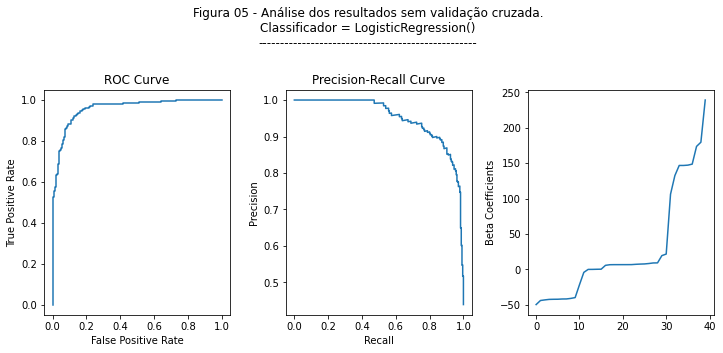

In [22]:
# Criar canvas para plotar os gráficos
fig5 = plt.figure(constrained_layout=True, figsize=(12,5))
fig5.suptitle('Figura 05 - Análise dos resultados sem validação cruzada.\n'+
              'Classificador = LogisticRegression()\n'+'-'*50)
# Criar gridspec
gs = gridspec.GridSpec(nrows=1, ncols=3, hspace=0.2, wspace=0.3)

# Plotar ROC Curve
ax1 = fig5.add_subplot(gs[0,0])
ax1.plot(lrModel.summary.roc.select('FPR').collect(),
         lrModel.summary.roc.select('TPR').collect())
ax1.set_title('ROC Curve')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')

# Plotar Precision-Recall Curve
ax2 = fig5.add_subplot(gs[0,1])
ax2.plot(lrModel.summary.pr.select('recall').collect(),
         lrModel.summary.pr.select('precision').collect())
ax2.set_title('Precision-Recall Curve')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

# Plotar principais métricas de avaliação
ax3 = fig5.add_subplot(gs[0,-1])
beta = np.sort(lrModel.coefficients)
ax3.plot(beta)
ax3.set_ylabel('Beta Coefficients')

plt.subplots_adjust(top=0.75)
plt.savefig("Figura05_ROC_PR_Crurves-LogisticRegression.png", transparent=True)

In [23]:
# Métricas para avaliar desempenho em treinamento
result_train = {'Recall':lrModel.summary.weightedRecall,
                'Precision':lrModel.summary.weightedPrecision,
                'F1-Score':lrModel.summary.weightedFMeasure(),
                'AreaUnderROC':lrModel.summary.areaUnderROC}
df_results = pd.DataFrame(index=list(k for k in result_train.keys()))
df_results['Desempenho em Treino']= list(v for v in result_train.values())

# Instanciar avaliadores
metrics_binary = BinaryClassificationMetrics(preds_and_labels_lr.rdd.map(tuple))
metrics_multi = MulticlassMetrics(preds_and_labels_lr.rdd.map(tuple))
# Métricas para avaliar desempenho em teste
result_test = {'Recall':metrics_multi.recall(1.0),
               'Precision':metrics_multi.precision(1.0),
               'F1-Score':metrics_multi.fMeasure(1.0),
               'AreaUnderROC':metrics_binary.areaUnderROC}

df_results['Desempenho em Teste']= list(v for v in result_test.values())
df_results.head()

,Desempenho em Treino,Desempenho em Teste
Recall,0.895327,0.815385
Precision,0.896067,0.803030
F1-Score,0.895496,0.809160
AreaUnderROC,0.959234,0.816143


### Tentativa de otimização utilizando validação cruzada

>* Spark oferece também ferramentas de otimização e seleção de hiperparâmetros para ML, dentro do módulo [`pyspark.ml.tuning`](https://spark.apache.org/docs/latest/ml-tuning.html "Clique para acessar a documentação - pyspark.ml.tuning"). Muitos algoritmos possuem vários hiperparâmetros que muitas das vezes só conseguem ser definidos empiricamente, rodando diversas configurações ou empregando técnicas de _busca em grade_. 
* Para uma busca em grade - `GridSearch`, Spark oferece o objeto `ParamGridBuilder`. Esse recurso deve ser empregado em conjunto com um mecanismo de _Validação Cruzada_, executado com um `CrossValidator`. 
* A Validação Cruzada é uma maneira muito eficiente de fazer otimização de parâmetros, pois é executada em diversas repartições dos dados de treinamento e oferece diversas visões de como um modelo se comporta. 


In [29]:
# Criar grid 
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01,0.1,0.5,1]) \
    .addGrid(lr.elasticNetParam, [0, 0.5, 1]) \
    .addGrid(lr.maxIter, [100,500,1000]).build()

#criando um avaliador
evaluator = BinaryClassificationEvaluator().setLabelCol('Y_bin')

# Rodar validação cruzada
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)
# Realizar treinamento com o conjunto de dados de treinamento
cvModel_lr = crossval.fit(df_train_vec)
# Realizar predições com o conjunto de dados de teste
predictions_cv_lr = cvModel_lr.transform(df_test_vec)
# Criar objeto para armazenar as predições
preds_and_labels_cv_lr = predictions_cv_lr.select(['prediction','Y_bin'])

In [30]:
# Instanciar avaliadores
metrics_binary_cv = BinaryClassificationMetrics(preds_and_labels_cv_lr.rdd.map(tuple))
metrics_multi_cv = MulticlassMetrics(preds_and_labels_cv_lr.rdd.map(tuple))
# Métricas para avaliar desempenho em teste com CrossValidator
result_test = {'Recall':metrics_multi_cv.recall(1.0),
               'Precision':metrics_multi_cv.precision(1.0),
               'F1-Score':metrics_multi_cv.fMeasure(1.0),
               'AreaUnderROC':metrics_binary_cv.areaUnderROC}

df_results['Desempenho em Teste - CrossValidator']= list(v for v in result_test.values())
df_results.head()

,Desempenho em Treino,Desempenho em Teste,Desempenho em Teste - CrossValidator
Recall,0.895327,0.815385,0.753846
Precision,0.896067,0.803030,0.844828
F1-Score,0.895496,0.809160,0.796748
AreaUnderROC,0.959234,0.816143,0.813543


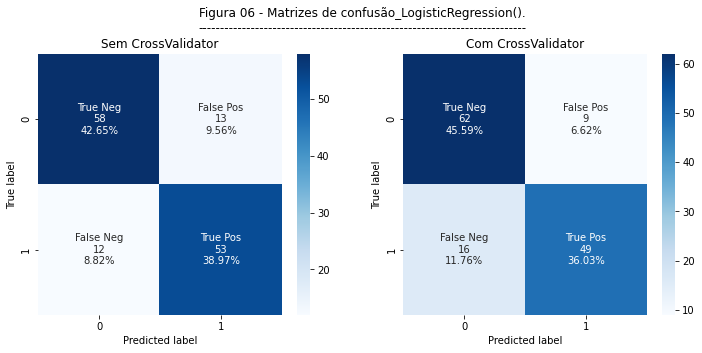

In [31]:
fig6 = plt.figure(constrained_layout=False, figsize=(12,5))
fig6.suptitle('Figura 06 - Matrizes de confusão_LogisticRegression().\n'+'-'*75)
# Criar gridspec
gs = gridspec.GridSpec(nrows=1, ncols=2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

# Plotar matriz de confusão sem CrossValidator
# Calcular matriz de confusão
cf_lr = metrics_multi.confusionMatrix().toArray()
# Plotar
ax1 = fig6.add_subplot(gs[0,0]) 
group_counts = ["{0:0.0f}".format(value) for value in cf_lr.flatten()]
group_percentages = ["{0:0.2%}".format(value) for value in cf_lr.flatten()/np.sum(cf_lr)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax1 = sns.heatmap(cf_lr, annot=labels, fmt='', cmap='Blues')
ax1.set_title('Sem CrossValidator')
ax1.set_xlabel('Predicted label')
ax1.set_ylabel('True label')

# Plotar matriz de confusão com CrossValidator
# Calcular matriz de confusão
cf_cv_lr = metrics_multi_cv.confusionMatrix().toArray()
# Plotar
ax2 = fig6.add_subplot(gs[0,1])
group_counts = ["{0:0.0f}".format(value) for value in cf_cv_lr.flatten()]
group_percentages = ["{0:0.2%}".format(value) for value in cf_cv_lr.flatten()/np.sum(cf_cv_lr)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax1 = sns.heatmap(cf_cv_lr, annot=labels, fmt='', cmap='Blues')
ax1.set_title('Com CrossValidator')
ax1.set_xlabel('Predicted label')
ax1.set_ylabel('True label')

plt.subplots_adjust(top=0.85)
plt.savefig("Figura06_MatrizesConfusao-LogisticRegression.png", transparent=True)